In [1]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [2]:
!pip install kmodes
!pip install catboost


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
import shap


In [4]:
df = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv",sep="\t")
pd.set_option('display.max_columns', None)

In [5]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Feature Engineering¶
# 

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
# income is the only column with null values. so I delete those rows/
df = df.dropna(subset=['Income']).reset_index(drop=True) 

below 
1) I combine binary variables in columns 20-24+28 into one column since they all point to the same question: whether the customer responded positively to a campaign by making a purchase

2) creating a new column age and enrollment_time and deleting year_birth and Dt_customer columns

3) livingwith column that simplifies marital status column by assingin 1 to together and 0 to single status.

4) children column that combines kidhome and teenhome columns.

5) simplify the education column by giving undergraduate degrees 0, graduate 1 and postgraduate 2

6) combining 5 accetedcmp columns  with response columns.



In [7]:
# renaming the response column as 6'th acceptedcmp because it shows whether the customer responded positively to the last campaing
df = df.rename(columns={'Response': 'AcceptedCmp6'})

df['Camp_responses']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['AcceptedCmp6']
campaign_dict = {'AcceptedCmp1': 1, 'AcceptedCmp2': 2, 'AcceptedCmp3': 3,
                 'AcceptedCmp4': 4, 'AcceptedCmp5': 5, 'AcceptedCmp6': 6}

df.drop(columns=campaign_dict.keys(), inplace=True)

# calculate age based on Year_Birth
current_year = dt.datetime.now().year
df['Age'] = current_year - df['Year_Birth']

# convert 'Dt_Customer' to datetime format and calculate enrollment time as number of months
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Enrollment_time'] = ((dt.datetime.now() - df['Dt_Customer']).dt.days / 12).round(1)

# drop the original columns
df.drop(columns=['Year_Birth', 'Dt_Customer'], inplace=True)

df["Living_With"]=df["Marital_Status"].replace({"Married":"1", "Together":"1", "Absurd":"0", "Widow":"0", "YOLO":"0", "Divorced":"0", "Single":"0",})

## To get a more clarity about family's background
df["Children"]=df["Kidhome"]+df["Teenhome"]
df.drop(columns=['Marital_Status', 'Kidhome', 'Teenhome'], inplace=True)


#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"0","2n Cycle":"0", "Graduation":"1", "Master":"2", "PhD":"2"})

# delete the redundant ID column
df.drop(columns=['ID'], inplace=True)



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Recency              2216 non-null   int64  
 3   MntWines             2216 non-null   int64  
 4   MntFruits            2216 non-null   int64  
 5   MntMeatProducts      2216 non-null   int64  
 6   MntFishProducts      2216 non-null   int64  
 7   MntSweetProducts     2216 non-null   int64  
 8   MntGoldProds         2216 non-null   int64  
 9   NumDealsPurchases    2216 non-null   int64  
 10  NumWebPurchases      2216 non-null   int64  
 11  NumCatalogPurchases  2216 non-null   int64  
 12  NumStorePurchases    2216 non-null   int64  
 13  NumWebVisitsMonth    2216 non-null   int64  
 14  Complain             2216 non-null   int64  
 15  Z_CostContact        2216 non-null   i

some of these columns are indeed categorical such as education(3 values), Camp_reponses(6  values), children(3 values), complain(binary) and living with(binary).That is why, I convert these variables into type 'string'.  But why not use some sort of labeling or encoding and feed them into a clustering algorithm such as Kmeans? 

Traditional clustering algoritms such as dbscan kmeans and hierarchical clustering are based on numeral distance and are known to be not working for non-continuous [variables](https://ijseas.com/volume2/v2i2/ijseas20160238.pdf). That's why, I would have to use K-mode clustering for categorical values and k-means for continous variables. Luckily, [kprototype](https://www.sciencedirect.com/science/article/abs/pii/S0925231213004773) uses both of those methods for mixed datasets such as the this dataset. 



In [95]:
df['Education'] = df['Education'].astype('string')
df['Living_With'] = df['Living_With'].astype('string')
# df['Children'] = df['Children'].astype('string')
# df['Camp_reponses'] = df['Camp_responses'].astype('string')
df['Complain'] = df['Complain'].astype('string')

# ALL COlumns need to be either integer or string for some of the models I will call below. 
df['Enrollment_time'] = df['Enrollment_time'].astype('int')
df['Income'] = df['Income'].astype('int')


OUTLIER DETECTION

Starting with whiskers plot of each integer variables is a good idea to detect outliers 

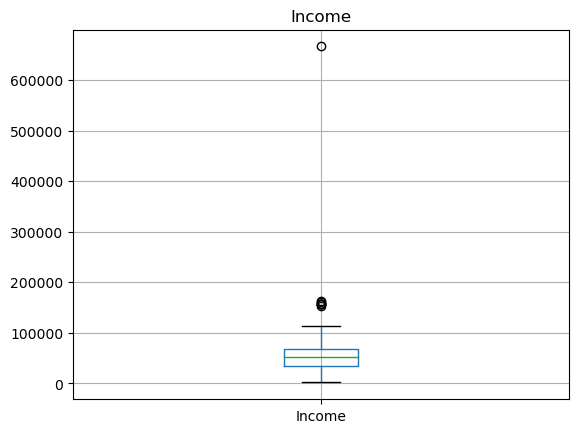

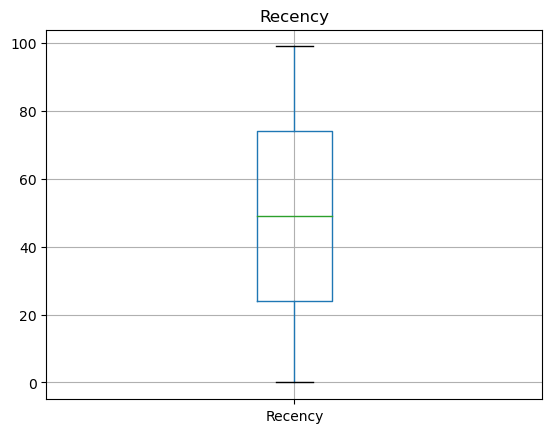

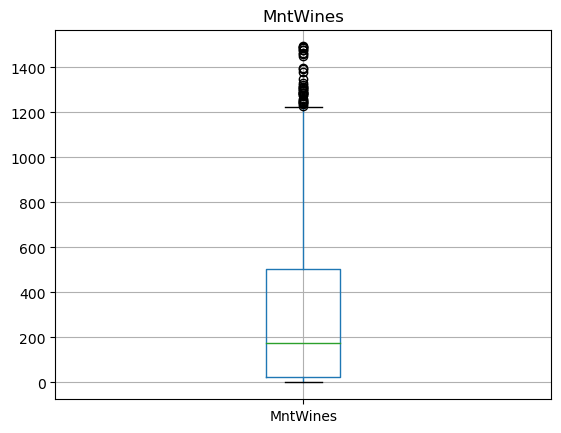

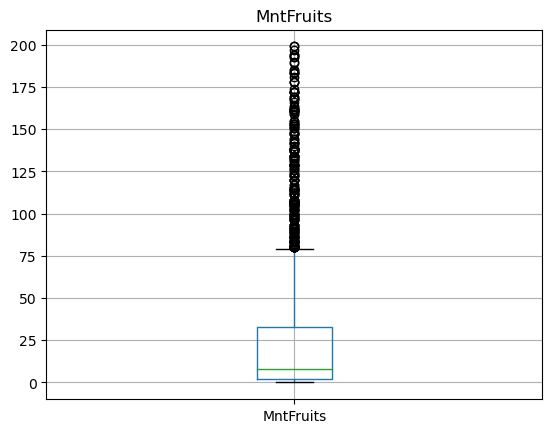

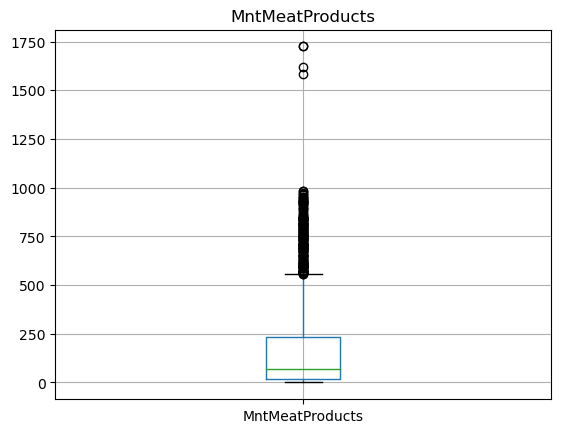

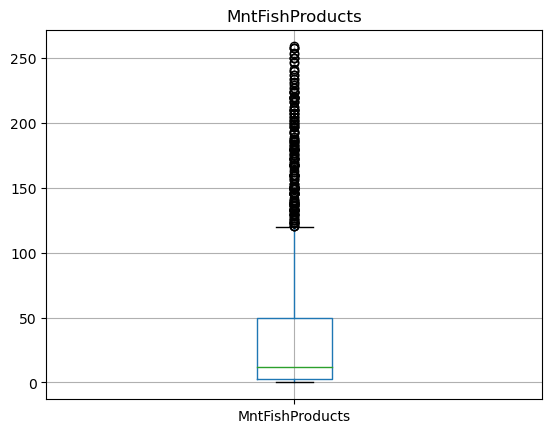

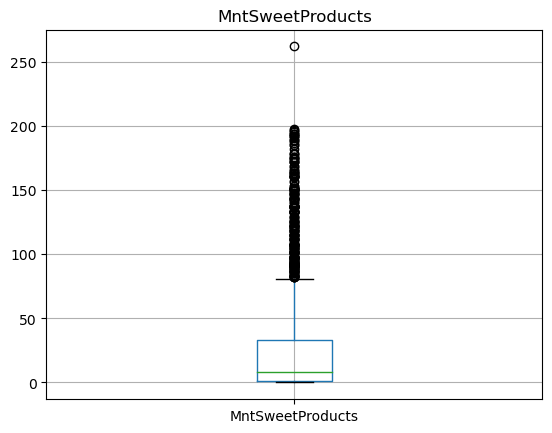

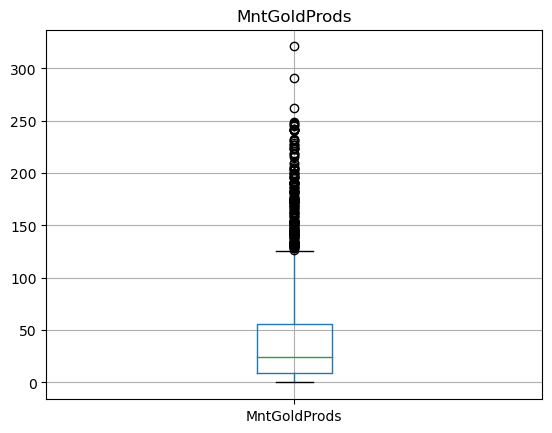

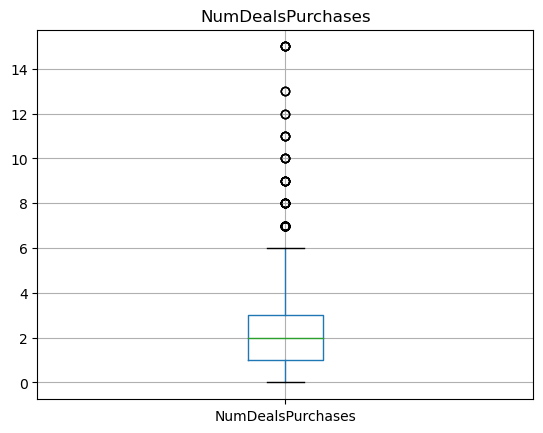

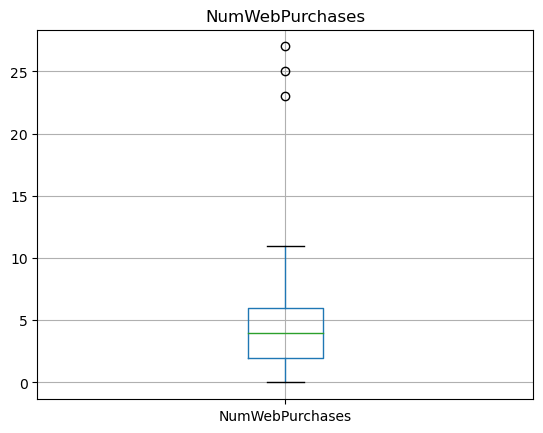

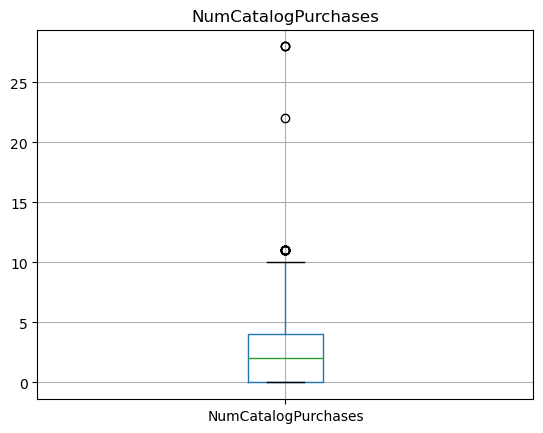

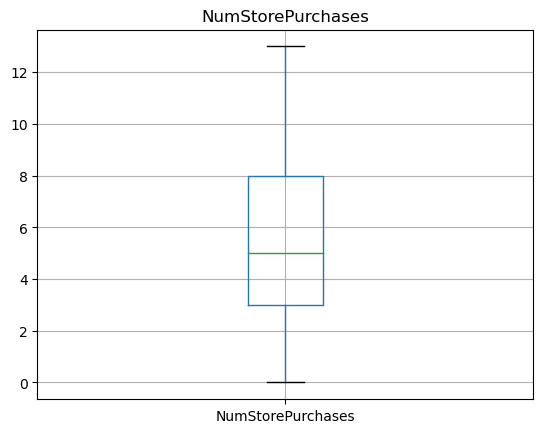

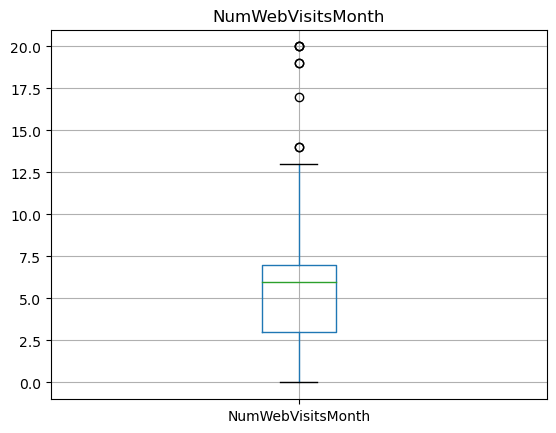

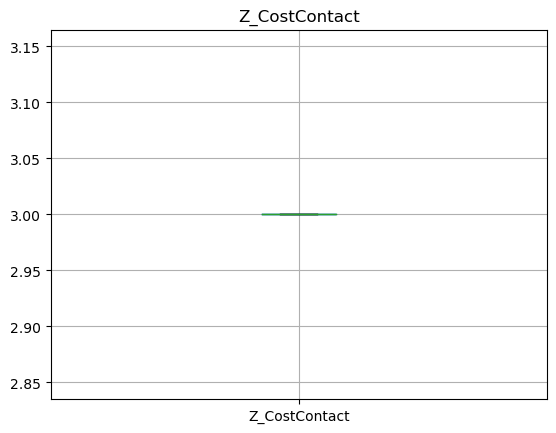

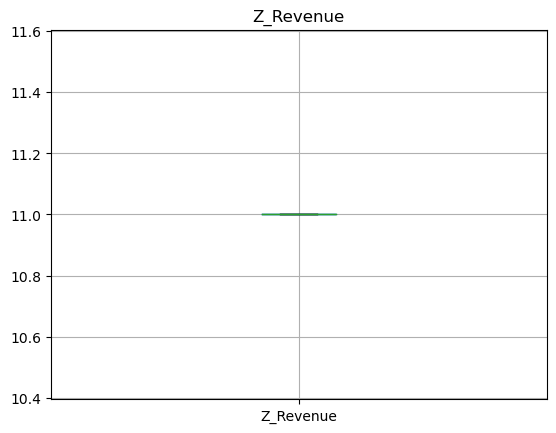

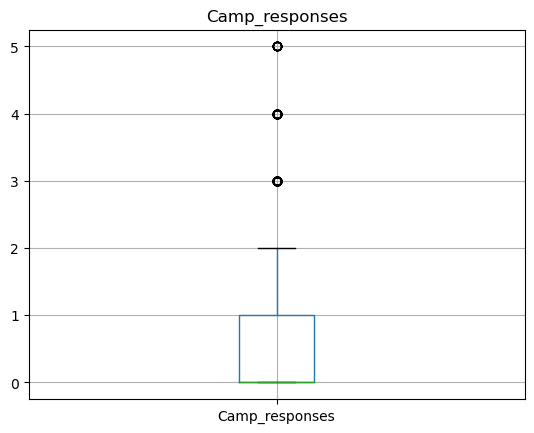

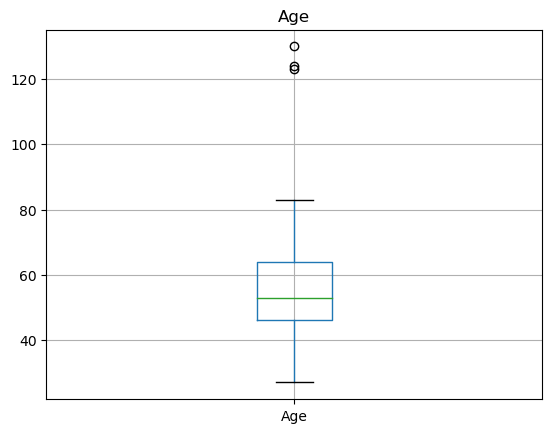

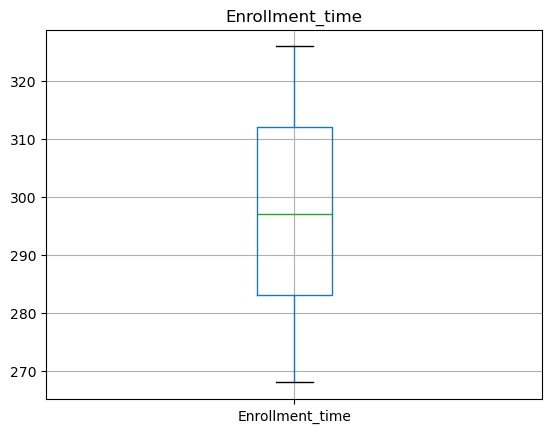

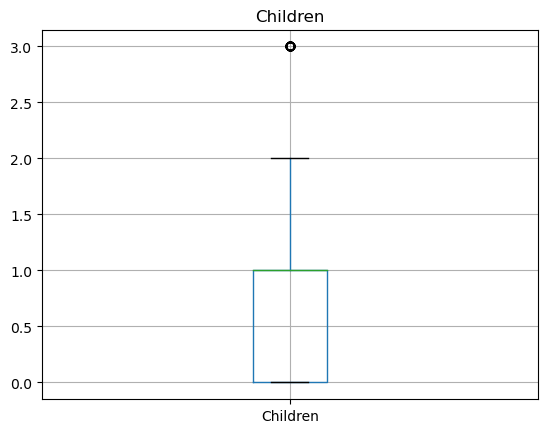

In [96]:
# Filter out string columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Create box plots for each numeric column
for col in numeric_cols:
    df[[col]].boxplot()
    plt.title(col)
    plt.show()


In [97]:
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    a = q1 - 1.5 * iqr
    b = q3 + 1.5 * iqr
    outliers = df[(df[col] < a) | (df[col] > b)]
    outlier_index = outliers.index
    df.drop(outlier_index, inplace=True)
df.reset_index()

,index,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Z_CostContact,Z_Revenue,Camp_responses,Age,Enrollment_time,Living_With,Children
0,1,1,46344,38,11,1,6,2,1,6,2,1,1,2,5,0,3,11,0,69,277,0,2
1,3,1,26646,26,11,4,20,10,3,5,2,2,0,4,6,0,3,11,0,39,279,1,1
2,7,2,33454,32,76,10,56,3,1,23,2,4,0,4,8,0,3,11,0,38,302,1,1
3,10,0,7500,59,6,16,11,11,1,16,1,2,0,3,8,0,3,11,0,47,317,1,0
4,12,2,59354,53,233,2,53,3,5,14,3,6,1,5,6,0,3,11,0,71,287,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,2199,0,7500,7,2,8,11,3,8,21,4,3,2,2,7,0,3,11,0,44,303,1,1
833,2200,2,33562,33,21,12,12,0,3,3,3,2,0,4,4,0,3,11,0,60,268,1,3
834,2205,1,24434,9,3,2,8,20,0,17,2,2,1,2,7,0,3,11,0,51,271,1,2
835,2208,1,26816,50,5,1,6,3,4,3,1,0,0,3,4,0,3,11,0,37,324,0,0


In [98]:
df.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Camp_responses,Age,Enrollment_time,Children
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.00000,837.000000,837.0,837.0,837.0,837.000000,837.000000,837.000000
mean,34771.143369,51.028674,41.080048,4.286738,20.982079,6.048984,4.000000,12.357228,1.988053,2.097969,0.440860,3.23417,6.344086,3.0,11.0,0.0,51.997611,293.767025,1.273596
std,12024.378774,28.805056,54.287662,6.225160,22.676230,7.469955,4.951197,12.388652,1.162554,1.345721,0.607295,0.82144,1.601772,0.0,0.0,0.0,11.057483,16.152220,0.697180
min,7500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.00000,1.000000,3.0,11.0,0.0,28.000000,268.000000,0.000000
25%,26091.000000,26.000000,8.000000,0.000000,7.000000,0.000000,0.000000,4.000000,1.000000,1.000000,0.000000,3.00000,5.000000,3.0,11.0,0.0,44.000000,279.000000,1.000000
50%,34421.000000,51.000000,20.000000,2.000000,14.000000,3.000000,2.000000,8.000000,2.000000,2.000000,0.000000,3.00000,7.000000,3.0,11.0,0.0,51.000000,293.000000,1.000000
75%,42997.000000,77.000000,50.000000,6.000000,25.000000,8.000000,6.000000,17.000000,3.000000,3.000000,1.000000,4.00000,8.000000,3.0,11.0,0.0,60.000000,307.000000,2.000000
max,69139.000000,99.000000,365.000000,51.000000,206.000000,47.000000,25.000000,66.000000,6.000000,8.000000,2.000000,5.00000,10.000000,3.0,11.0,0.0,83.000000,326.000000,3.000000


as seen in the box plots

In [99]:
# deleting the z_costcontact and Z_revenue columns as they have zero variation and therefore no use for clustering purposes 
df = df.drop(columns=['Z_CostContact', 'Z_Revenue'])
df.reset_index()

,index,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Camp_responses,Age,Enrollment_time,Living_With,Children
0,1,1,46344,38,11,1,6,2,1,6,2,1,1,2,5,0,0,69,277,0,2
1,3,1,26646,26,11,4,20,10,3,5,2,2,0,4,6,0,0,39,279,1,1
2,7,2,33454,32,76,10,56,3,1,23,2,4,0,4,8,0,0,38,302,1,1
3,10,0,7500,59,6,16,11,11,1,16,1,2,0,3,8,0,0,47,317,1,0
4,12,2,59354,53,233,2,53,3,5,14,3,6,1,5,6,0,0,71,287,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,2199,0,7500,7,2,8,11,3,8,21,4,3,2,2,7,0,0,44,303,1,1
833,2200,2,33562,33,21,12,12,0,3,3,3,2,0,4,4,0,0,60,268,1,3
834,2205,1,24434,9,3,2,8,20,0,17,2,2,1,2,7,0,0,51,271,1,2
835,2208,1,26816,50,5,1,6,3,4,3,1,0,0,3,4,0,0,37,324,0,0


In [100]:
df.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Camp_responses,Age,Enrollment_time,Living_With,Children
1,1,46344,38,11,1,6,2,1,6,2,1,1,2,5,0,0,69,277,0,2
3,1,26646,26,11,4,20,10,3,5,2,2,0,4,6,0,0,39,279,1,1
7,2,33454,32,76,10,56,3,1,23,2,4,0,4,8,0,0,38,302,1,1
10,0,7500,59,6,16,11,11,1,16,1,2,0,3,8,0,0,47,317,1,0
12,2,59354,53,233,2,53,3,5,14,3,6,1,5,6,0,0,71,287,0,2


In [101]:
df = df.reset_index(drop=True)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education            837 non-null    string
 1   Income               837 non-null    int64 
 2   Recency              837 non-null    int64 
 3   MntWines             837 non-null    int64 
 4   MntFruits            837 non-null    int64 
 5   MntMeatProducts      837 non-null    int64 
 6   MntFishProducts      837 non-null    int64 
 7   MntSweetProducts     837 non-null    int64 
 8   MntGoldProds         837 non-null    int64 
 9   NumDealsPurchases    837 non-null    int64 
 10  NumWebPurchases      837 non-null    int64 
 11  NumCatalogPurchases  837 non-null    int64 
 12  NumStorePurchases    837 non-null    int64 
 13  NumWebVisitsMonth    837 non-null    int64 
 14  Complain             837 non-null    string
 15  Camp_responses       837 non-null    int64 
 16  Age     

In [103]:
# select columns with data type 'object'
object_cols = df.select_dtypes(include=['string']).columns

# get the index of the object columns
object_cols_index = object_cols.to_list()

object_cols_index = [df.columns.get_loc(col) for col in object_cols]


print(object_cols_index)  


[0, 14, 18]


In [104]:
df_scaled=df.copy()
# select only the non-object columns
non_obj_cols = df_scaled.select_dtypes(exclude=['string']).columns

# apply robust standization to the non-object columns as there are outliers in the data. 
scaler = RobustScaler()
df_scaled[non_obj_cols] = scaler.fit_transform(df_scaled[non_obj_cols])


df_scaled.describe().round()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Camp_responses,Age,Enrollment_time,Children
count,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0
mean,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
min,-2.0,-1.0,-0.0,-0.0,-1.0,-0.0,-0.0,-1.0,-0.0,-1.0,0.0,-1.0,-2.0,0.0,-1.0,-1.0,-1.0
25%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-1.0,0.0,-0.0,-0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
max,2.0,1.0,8.0,8.0,11.0,6.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,0.0,2.0,1.0,2.0


applying the elbow method 

In [105]:
cost = []
for num_clusters in list(range(1,8)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(df_scaled, categorical=object_cols_index)
    cost.append(kproto.cost_)




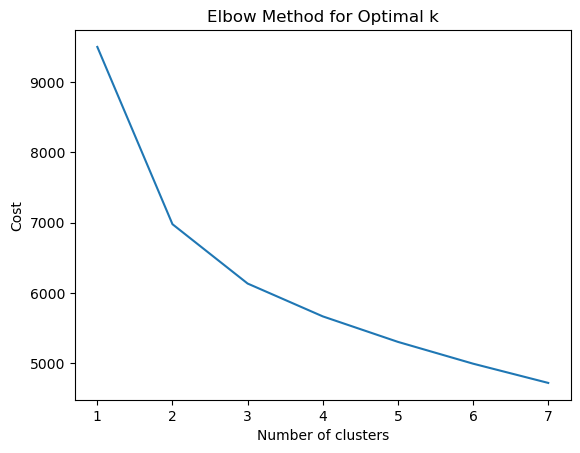

In [106]:
plt.plot(range(1, 8), cost)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

K=3 seems like a good choice. so lets re-train with k=3 this time with more initializations.

In [107]:
    kproto = KPrototypes(n_clusters=3, init='Cao', n_init=50)
    kproto.fit_predict(df_scaled, categorical=object_cols_index)


array([1, 1, 2, 0, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 2, 2, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1,
       1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 0, 0, 2, 1, 0, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1,
       1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       0, 1, 1, 0, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0,

I add the labels to the original DF since I will apply Catboost to now labeled dataset to understand feature importance through SHAP values.

In [108]:
df['cluster']=kproto.labels_
df.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Camp_responses,Age,Enrollment_time,Living_With,Children,cluster
0,1,46344,38,11,1,6,2,1,6,2,1,1,2,5,0,0,69,277,0,2,1
1,1,26646,26,11,4,20,10,3,5,2,2,0,4,6,0,0,39,279,1,1,1
2,2,33454,32,76,10,56,3,1,23,2,4,0,4,8,0,0,38,302,1,1,2
3,0,7500,59,6,16,11,11,1,16,1,2,0,3,8,0,0,47,317,1,0,0
4,2,59354,53,233,2,53,3,5,14,3,6,1,5,6,0,0,71,287,0,2,2


there is no need for train test split and worry about overfitting because we wont use the model for prediction purposes but to explore which features are important for each of the three clusters. So I first train a 
catboos model for the existence of many categorical features. I will then analyze feature importance through SHAP values. 

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education            837 non-null    string
 1   Income               837 non-null    int64 
 2   Recency              837 non-null    int64 
 3   MntWines             837 non-null    int64 
 4   MntFruits            837 non-null    int64 
 5   MntMeatProducts      837 non-null    int64 
 6   MntFishProducts      837 non-null    int64 
 7   MntSweetProducts     837 non-null    int64 
 8   MntGoldProds         837 non-null    int64 
 9   NumDealsPurchases    837 non-null    int64 
 10  NumWebPurchases      837 non-null    int64 
 11  NumCatalogPurchases  837 non-null    int64 
 12  NumStorePurchases    837 non-null    int64 
 13  NumWebVisitsMonth    837 non-null    int64 
 14  Complain             837 non-null    string
 15  Camp_responses       837 non-null    int64 
 16  Age     

In [110]:

df['cluster'] = df['cluster'].astype('int')


In [111]:
X = df.drop('cluster', axis=1)
y = df['cluster']

catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function='MultiClass', eval_metric='Accuracy', random_seed=42)

catboost.fit(X, y, cat_features=object_cols_index)




0:	learn: 0.8542413	total: 6.41ms	remaining: 635ms
1:	learn: 0.9259259	total: 10.6ms	remaining: 517ms
2:	learn: 0.9462366	total: 14.2ms	remaining: 458ms
3:	learn: 0.9414576	total: 18ms	remaining: 432ms
4:	learn: 0.9605735	total: 24.8ms	remaining: 472ms
5:	learn: 0.9581840	total: 30.4ms	remaining: 476ms
6:	learn: 0.9629630	total: 37ms	remaining: 491ms
7:	learn: 0.9641577	total: 43.7ms	remaining: 503ms
8:	learn: 0.9677419	total: 47.5ms	remaining: 480ms
9:	learn: 0.9641577	total: 50.8ms	remaining: 457ms
10:	learn: 0.9665472	total: 54.2ms	remaining: 439ms
11:	learn: 0.9701314	total: 59.1ms	remaining: 434ms
12:	learn: 0.9665472	total: 63.6ms	remaining: 426ms
13:	learn: 0.9701314	total: 67.3ms	remaining: 413ms
14:	learn: 0.9689367	total: 70.3ms	remaining: 399ms
15:	learn: 0.9677419	total: 73.5ms	remaining: 386ms
16:	learn: 0.9737157	total: 76.6ms	remaining: 374ms
17:	learn: 0.9725209	total: 80.1ms	remaining: 365ms
18:	learn: 0.9737157	total: 83.3ms	remaining: 355ms
19:	learn: 0.9749104	total

[0, 1, 3, 4, 17, 18]


In [112]:
object_cols_index

[0, 14, 18]

In [113]:
explainer = shap.TreeExplainer(catboost, cat_features=object_cols_index)

# # Compute SHAP values for the training data
shap_values = explainer(X).values


In [114]:
shap_values.shape

(837, 20, 3)

In [115]:
X['Complain'].value_counts()


0    828
1      9
Name: Complain, dtype: Int64

In [116]:
X['Education'].value_counts()


1    412
2    293
0    132
Name: Education, dtype: Int64

In [117]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education            837 non-null    string
 1   Income               837 non-null    int64 
 2   Recency              837 non-null    int64 
 3   MntWines             837 non-null    int64 
 4   MntFruits            837 non-null    int64 
 5   MntMeatProducts      837 non-null    int64 
 6   MntFishProducts      837 non-null    int64 
 7   MntSweetProducts     837 non-null    int64 
 8   MntGoldProds         837 non-null    int64 
 9   NumDealsPurchases    837 non-null    int64 
 10  NumWebPurchases      837 non-null    int64 
 11  NumCatalogPurchases  837 non-null    int64 
 12  NumStorePurchases    837 non-null    int64 
 13  NumWebVisitsMonth    837 non-null    int64 
 14  Complain             837 non-null    string
 15  Camp_responses       837 non-null    int64 
 16  Age     

In [118]:
df['cluster'].unique()

array([1, 2, 0])

In [119]:
df['Living_With'].value_counts

<bound method IndexOpsMixin.value_counts of 0      0
1      1
2      1
3      1
4      0
      ..
832    1
833    1
834    1
835    0
836    1
Name: Living_With, Length: 837, dtype: string>

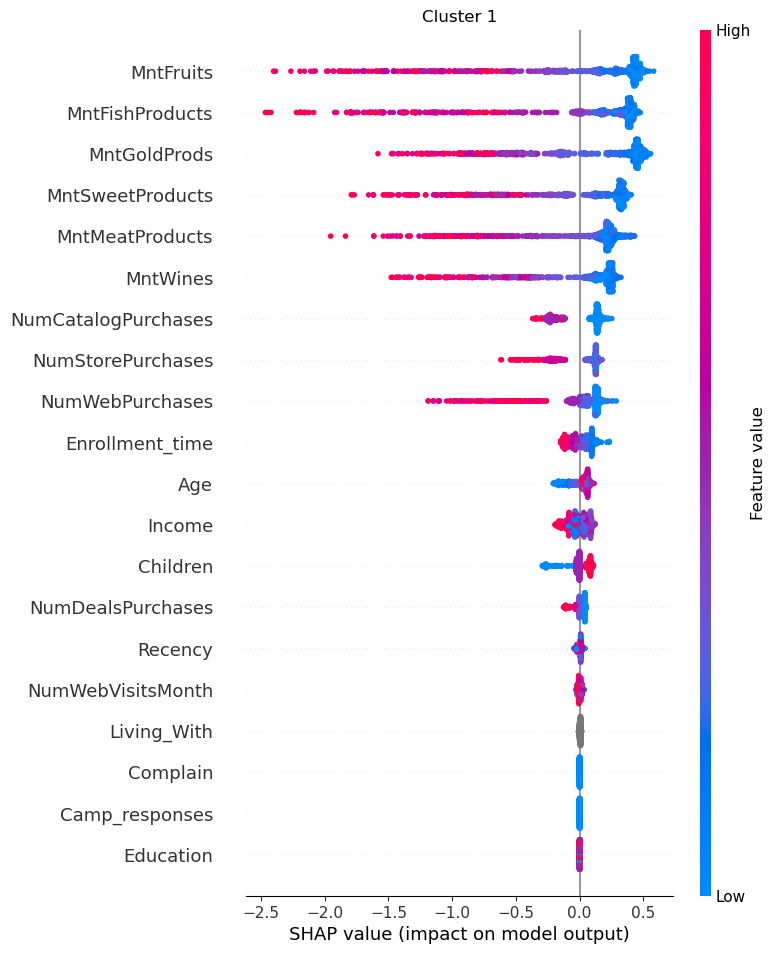

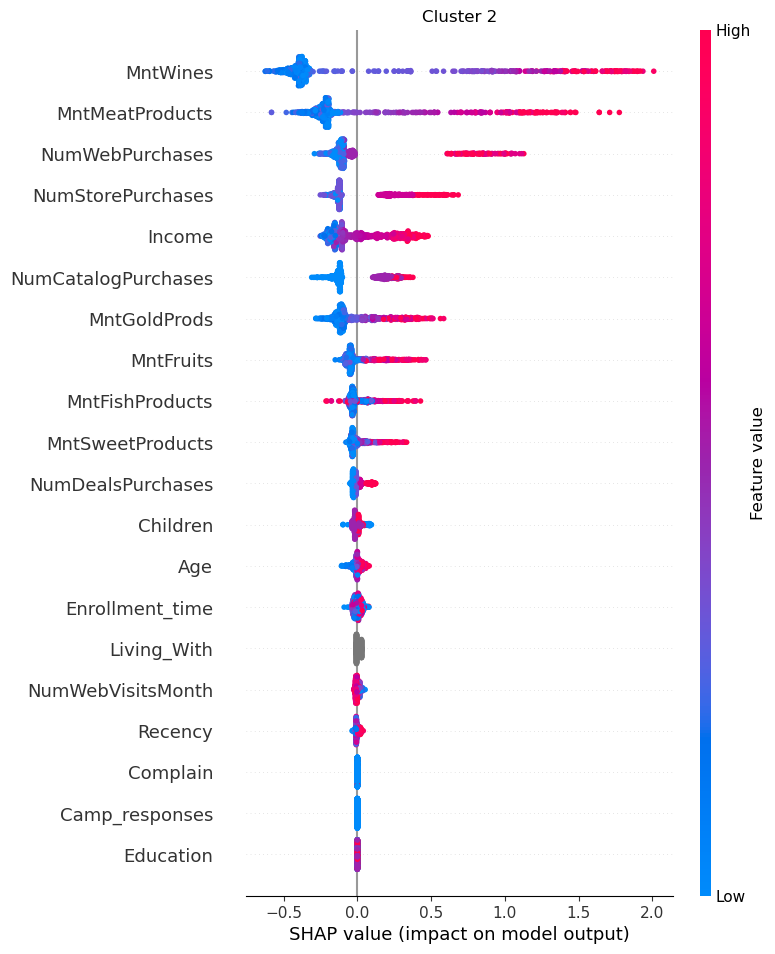

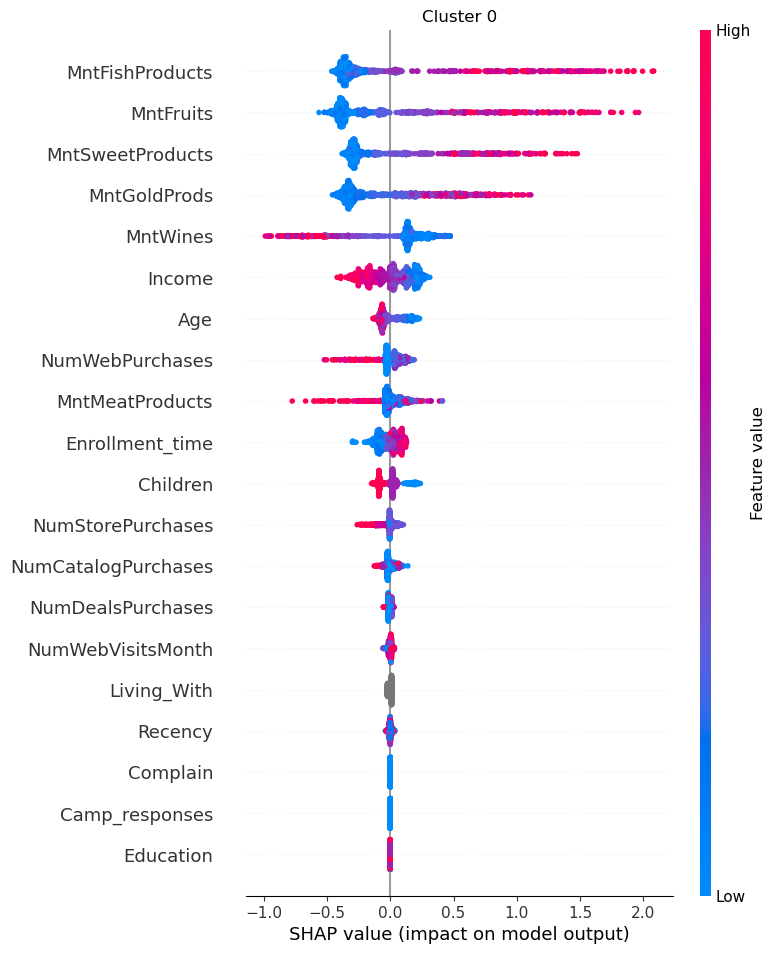

In [120]:
for cnr in df['cluster'].unique():
    shap.summary_plot(shap_values[:, :, cnr], X, max_display=30, show=False)
    plt.title(f'Cluster {cnr}')
    plt.show()